#1: Connecting to Drive Files

###Connects Google Colab to Google Drive so the notebook can access the dataset files

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2: Libraries
###Imports all libraries needed for the project

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image, ImageFilter
import torchvision.transforms.functional as TF
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import pandas as pd
import seaborn as sns


#3: Upload Dataset
###Defines a custom PyTorch dataset that loads wound images and labels from a CSV file, maps labels into three severity levels (Minor, Moderate, Severe), and applies image transformations

In [19]:
class WoundDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, img_ext=".jpg"):
        self.data = pd.read_csv(csv_file)

        self.data = self.data[~self.data['index'].str.startswith('BG/')]

        self.root_dir = root_dir
        self.transform = transform
        self.img_ext = img_ext

        self.data['index'] = self.data['index'].str.replace('\\', '/', regex=False)
        self.data['index'] = self.data['index'].apply(
            lambda x: x if os.path.splitext(x)[1] else x + self.img_ext
        )

    def map_label(self, label):
        if label in [0, 1]:
            return 0  # Minor
        elif label in [2, 3]:
            return 1  # Moderate
        else:
            return 2  # Severe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_rel_path = self.data.iloc[idx]['index']
        img_path = os.path.join(self.root_dir, img_rel_path)

        image = Image.open(img_path).convert("RGB")
        original_label = int(self.data.iloc[idx]['Labels'])
        label = self.map_label(original_label)

        if self.transform:
            image = self.transform(image)

        return image, label


#4: Transform
###Defines image preprocessing and augmentation for training, prepares the test preprocessing, and creates dataset loaders for efficient batch training and evaluation

In [20]:
train_transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Test transform stays simple but must match the training size
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = WoundDataset(
    csv_file='/content/drive/MyDrive/Train/wound_locations_Labels_AZH_Train.csv',
    root_dir='/content/drive/MyDrive/Train',
    transform=train_transform
)

test_dataset = WoundDataset(
    csv_file='/content/drive/MyDrive/Test/wound_locations_Labels_AZH_Test.csv',
    root_dir='/content/drive/MyDrive/Test',
    transform=test_transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#5: Device
###Loads a pretrained ResNet-50 model, adds dropout for regularization, enables full fine-tuning, and sets up the loss function, optimizer, and learning rate scheduler for training

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=True)
num_ftrs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(num_ftrs, 3)
)

model = model.to(device)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = torch.tensor(alpha).to(device) if alpha else None

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none', weight=self.alpha)(inputs, targets)
        pt = torch.exp(-ce_loss)

        focal_loss = ((1 - pt + 1e-8) ** self.gamma * ce_loss).mean()
        return focal_loss

criterion = FocalLoss(gamma=2.0)

optimizer = optim.Adam(model.fc.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.2)

print("ResNet-50 | Softer Focal Loss | Higher LR")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet-50 | Softer Focal Loss | Higher LR


#6: Training Model
###Trains the neural network for 25 epochs, updating the model weights and reporting training loss and accuracy after each epoch

In [22]:
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Loss: {running_loss/len(train_loader):.4f} "
          f"Accuracy: {100*correct/total:.2f}%")

Epoch [1/25] Loss: 0.4994 Accuracy: 44.12%
Epoch [2/25] Loss: 0.4338 Accuracy: 51.85%
Epoch [3/25] Loss: 0.4043 Accuracy: 57.00%
Epoch [4/25] Loss: 0.3708 Accuracy: 60.06%
Epoch [5/25] Loss: 0.3613 Accuracy: 62.16%
Epoch [6/25] Loss: 0.3649 Accuracy: 61.67%
Epoch [7/25] Loss: 0.3425 Accuracy: 64.90%
Epoch [8/25] Loss: 0.3350 Accuracy: 66.34%
Epoch [9/25] Loss: 0.3359 Accuracy: 63.77%
Epoch [10/25] Loss: 0.3384 Accuracy: 65.54%
Epoch [11/25] Loss: 0.3295 Accuracy: 65.86%
Epoch [12/25] Loss: 0.3407 Accuracy: 66.34%
Epoch [13/25] Loss: 0.3204 Accuracy: 66.51%
Epoch [14/25] Loss: 0.3352 Accuracy: 67.47%
Epoch [15/25] Loss: 0.3200 Accuracy: 67.95%
Epoch [16/25] Loss: 0.3421 Accuracy: 63.12%
Epoch [17/25] Loss: 0.3220 Accuracy: 66.99%
Epoch [18/25] Loss: 0.3288 Accuracy: 68.76%
Epoch [19/25] Loss: 0.2925 Accuracy: 70.69%
Epoch [20/25] Loss: 0.3029 Accuracy: 68.28%
Epoch [21/25] Loss: 0.3032 Accuracy: 69.57%
Epoch [22/25] Loss: 0.3021 Accuracy: 69.40%
Epoch [23/25] Loss: 0.3043 Accuracy: 66.6

#7: Testing Model
###Evaluates the trained model on the test dataset and reports the overall classification accuracy

In [23]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100*correct/total:.2f}%")

Test Accuracy: 73.68%


#8: Predictions
###Displays random test images with blurred content for privacy, alongside the model’s predicted severity and the true label, allowing visual inspection of classification results

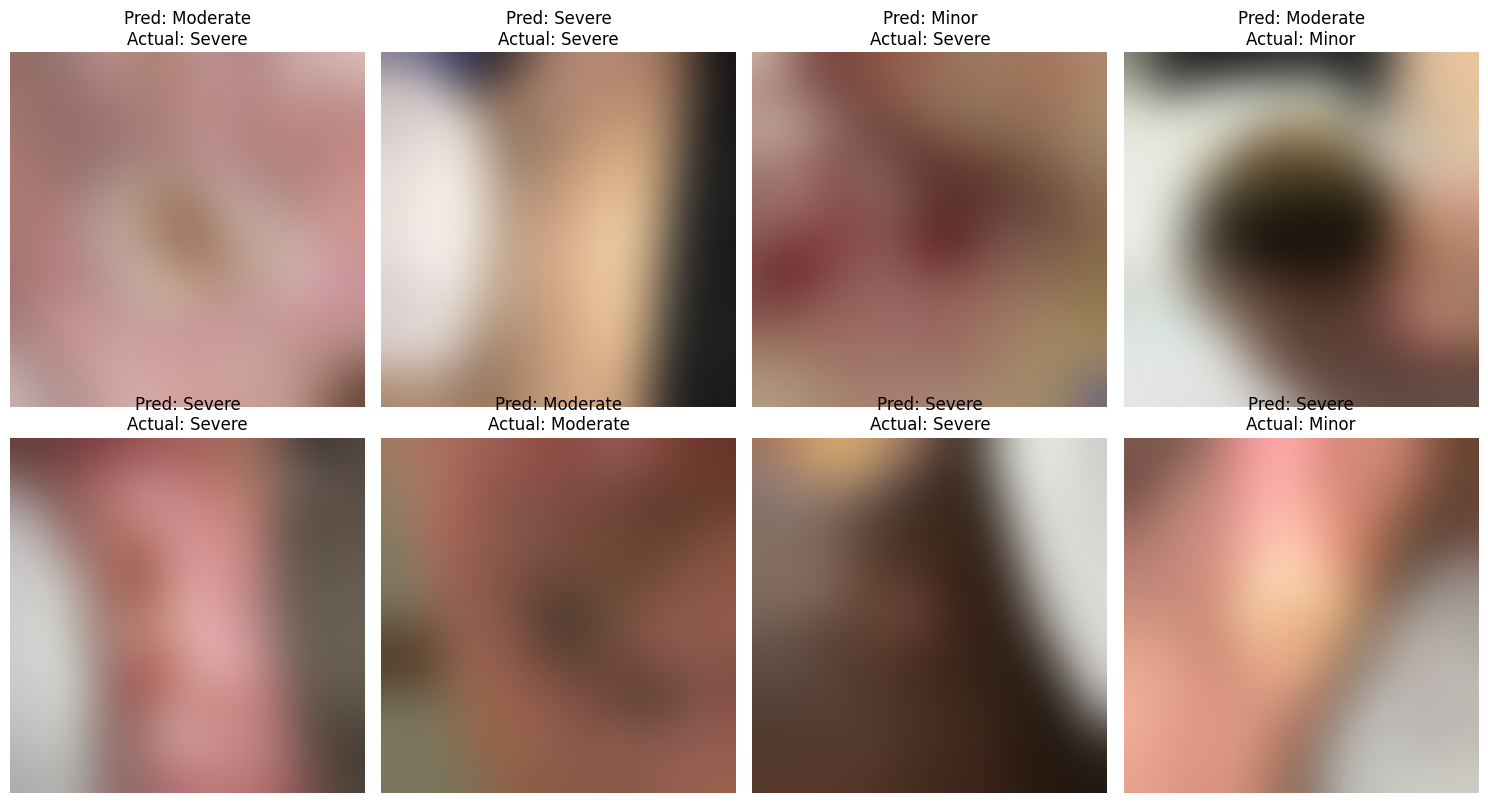

In [24]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def unnormalize(tensor, mean, std):
    for tensorI, meanI, stdI in zip(tensor, mean, std):
        tensorI.mul_(stdI).add_(meanI)
    return tensor

severity_names = {
    0: "Minor",
    1: "Moderate",
    2: "Severe",
}

def show_predictions_safe(model, dataset, device, num_images=8):
    model.eval()

    # Pick random indices from the dataset
    indices = random.sample(range(len(dataset)), num_images)

    plt.figure(figsize=(15, 8))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, label = dataset[idx]
            image_input = image.unsqueeze(0).to(device)
            output = model(image_input)
            _, pred = output.max(1)

            img = unnormalize(image.cpu(), IMAGENET_MEAN, IMAGENET_STD)
            img = TF.to_pil_image(img.clamp(0, 1))
            img = img.filter(ImageFilter.GaussianBlur(radius=15))

            plt.subplot(2, 4, i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Pred: {severity_names[pred.item()]}\nActual: {severity_names[label]}")

    plt.tight_layout()
    plt.show()

# Call it using the dataset directly, not the loader
show_predictions_safe(model, test_dataset, device)

#9: Training with Validation & Model Checkpointing

###Trains the model for 35 epochs while tracking training and validation loss/accuracy, adjusts learning rate with a scheduler, and saves the best-performing model based on validation accuracy

In [25]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0
num_epochs = 35

for epoch in range(num_epochs):

    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Validation
    model.eval()
    v_loss, v_correct, v_total = 0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            v_loss += loss.item()
            _, predicted = outputs.max(1)
            v_total += labels.size(0)
            v_correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    val_acc = 100 * v_correct / v_total

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(v_loss / len(test_loader))
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # -----------------------------
    # Progressive unfreezing EARLIER
    # -----------------------------
    if epoch == 2:
        for name, param in model.named_parameters():
            if "layer4" in name:
                param.requires_grad = True
        print("Unfroze layer4")

    if epoch == 6:
        for name, param in model.named_parameters():
            if "layer3" in name:
                param.requires_grad = True
        print("Unfroze layer3")

    # Update the scheduler after the optimizer has stepped
    scheduler.step()

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_wound_model.pth")
        best_msg = "--> SAVED"
    else:
        best_msg = ""

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | "
          f"LR: {optimizer.param_groups[0]['lr']:.7f} {best_msg}")


Epoch [1/35] | Train Acc: 67.47% | Val Acc: 73.21% | LR: 0.0003000 --> SAVED
Epoch [2/35] | Train Acc: 69.73% | Val Acc: 73.68% | LR: 0.0003000 --> SAVED
Unfroze layer4
Epoch [3/35] | Train Acc: 68.44% | Val Acc: 75.12% | LR: 0.0003000 --> SAVED
Epoch [4/35] | Train Acc: 62.80% | Val Acc: 73.68% | LR: 0.0003000 
Epoch [5/35] | Train Acc: 69.24% | Val Acc: 70.81% | LR: 0.0003000 
Epoch [6/35] | Train Acc: 74.72% | Val Acc: 78.95% | LR: 0.0000600 --> SAVED
Unfroze layer3
Epoch [7/35] | Train Acc: 77.29% | Val Acc: 80.38% | LR: 0.0000600 --> SAVED
Epoch [8/35] | Train Acc: 80.52% | Val Acc: 78.95% | LR: 0.0000600 
Epoch [9/35] | Train Acc: 79.55% | Val Acc: 78.95% | LR: 0.0000600 
Epoch [10/35] | Train Acc: 83.90% | Val Acc: 82.30% | LR: 0.0000600 --> SAVED
Epoch [11/35] | Train Acc: 85.35% | Val Acc: 79.90% | LR: 0.0000600 
Epoch [12/35] | Train Acc: 88.24% | Val Acc: 77.99% | LR: 0.0000120 
Epoch [13/35] | Train Acc: 89.21% | Val Acc: 79.43% | LR: 0.0000120 
Epoch [14/35] | Train Acc: 8

#10: Plot Training & Validation Metrics

###Visualizes the loss and accuracy over epochs for both training and validation sets, helping to monitor model performance and detect overfitting

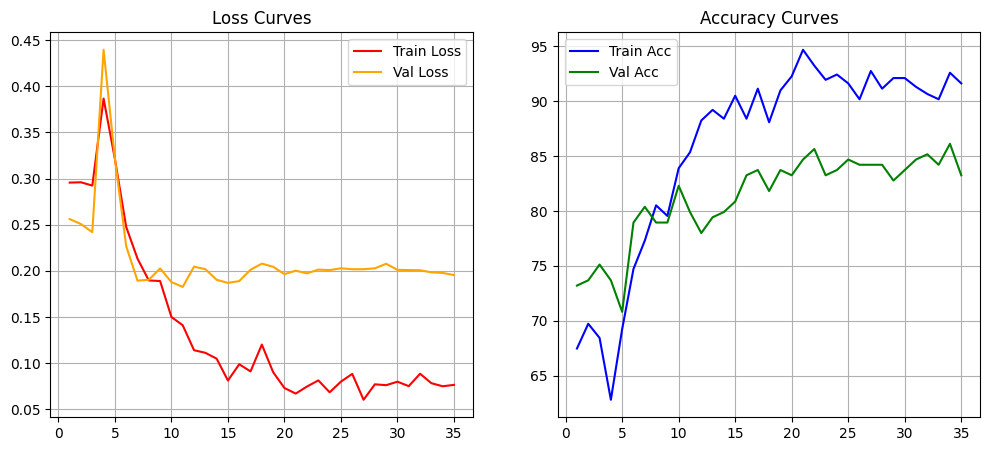

In [26]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss', color='red')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss', color='orange')
plt.title("Loss Curves")
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Acc', color='blue')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Val Acc', color='green')
plt.title("Accuracy Curves")
plt.legend(); plt.grid(True)

plt.show()

#11: Classification Report & Confusion Matrix

###Evaluates the model on the test set, prints precision, recall, and F1-scores for each severity class, and visualizes misclassifications using a confusion matrix

Classification Report:
              precision    recall  f1-score   support

       Minor       0.85      0.76      0.80        46
    Moderate       0.79      0.85      0.82        59
      Severe       0.90      0.91      0.91       104

    accuracy                           0.86       209
   macro avg       0.85      0.84      0.84       209
weighted avg       0.86      0.86      0.86       209



<Figure size 800x600 with 0 Axes>

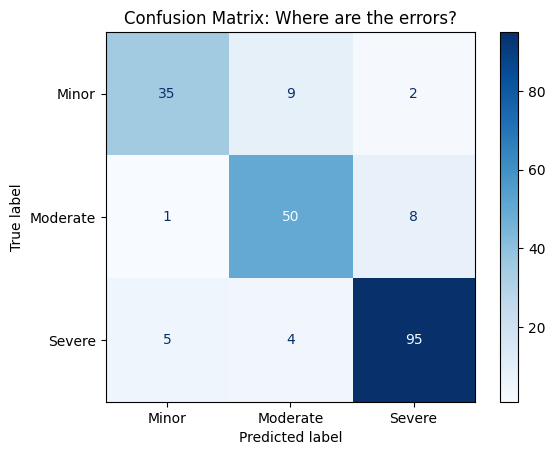

In [27]:
#Clear lists to ensure fresh evaluation
all_preds = []
all_labels = []

#Use the best saved model if available
model.load_state_dict(torch.load('best_wound_model.pth'))

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3. Print a detailed classification report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Minor", "Moderate", "Severe"]))

# 4. Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Minor", "Moderate", "Severe"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix: Where are the errors?")
plt.show()

#12: Scatter Plot of Predictions vs. Actual Labels

###Displays a scatter plot comparing predicted and true wound severities, highlighting correct predictions in green and misclassifications in red, to visualize model errors and overall prediction distribution

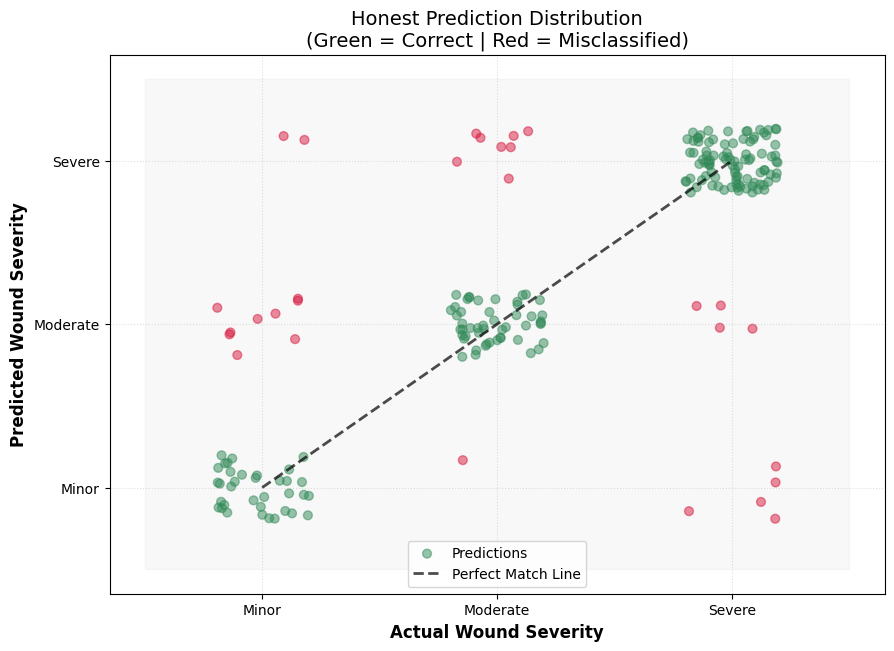

In [28]:
plt.figure(figsize=(10, 7))

# Wider jitter (0.2) to separate the clusters more clearly
jitter_labels = np.array(all_labels) + np.random.uniform(-0.2, 0.2, len(all_labels))
jitter_preds = np.array(all_preds) + np.random.uniform(-0.2, 0.2, len(all_preds))

# Color coding: Points near the line are "Correct", far away are "Wrong"
colors = np.where(np.array(all_labels) == np.array(all_preds), 'seagreen', 'crimson')

plt.scatter(jitter_labels, jitter_preds, alpha=0.5, c=colors, s=40, label="Predictions")
plt.plot([0, 2], [0, 2], 'k--', alpha=0.7, linewidth=2, label="Perfect Match Line")

# Formatting the plot for readability
plt.xticks([0, 1, 2], ["Minor", "Moderate", "Severe"])
plt.yticks([0, 1, 2], ["Minor", "Moderate", "Severe"])
plt.xlabel("Actual Wound Severity", fontsize=12, fontweight='bold')
plt.ylabel("Predicted Wound Severity", fontsize=12, fontweight='bold')
plt.title("Honest Prediction Distribution\n(Green = Correct | Red = Misclassified)", fontsize=14)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.4)

# Adding a background tint to emphasize the "Correct" diagonal
plt.fill_between([-0.5, 2.5], -0.5, 2.5, color='gray', alpha=0.05)

plt.show()

#13: Test-Time Augmentation (TTA) Evaluation

###Applies multiple augmented versions of each test image to improve prediction robustness and computes the averaged accuracy, comparing it to the standard test accuracy

In [29]:
# Test-Time Augmentation (TTA)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

tta_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20)
])

def test_with_tta(model, loader, device, num_augs=8):
    model.eval()
    total, correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            batch_size = images.size(0)

            probs = torch.zeros(batch_size, 3).to(device)

            for _ in range(num_augs):
                augmented = torch.stack([tta_transforms(img.cpu()) for img in images])
                augmented = augmented.to(device)
                outputs = model(augmented)
                probs += torch.softmax(outputs, dim=1)

            probs /= num_augs
            _, preds = probs.max(1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, all_preds, all_labels


#14: Final Model Audit

###Summarizes the model’s final performance with key metrics (precision, recall, F1-score) in a clean table and reports the overall accuracy after test-time augmentation

Test Accuracy with TTA: 81.82%


<Figure size 800x600 with 0 Axes>

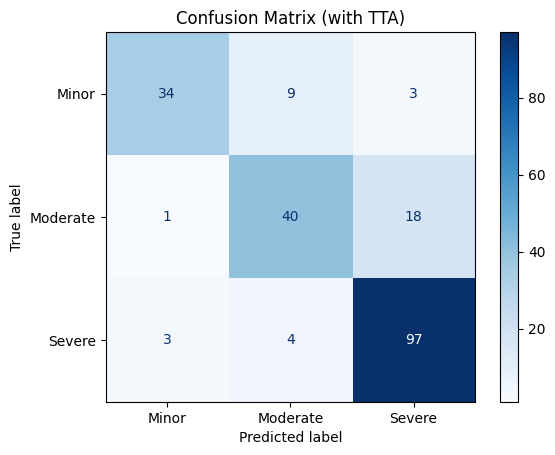

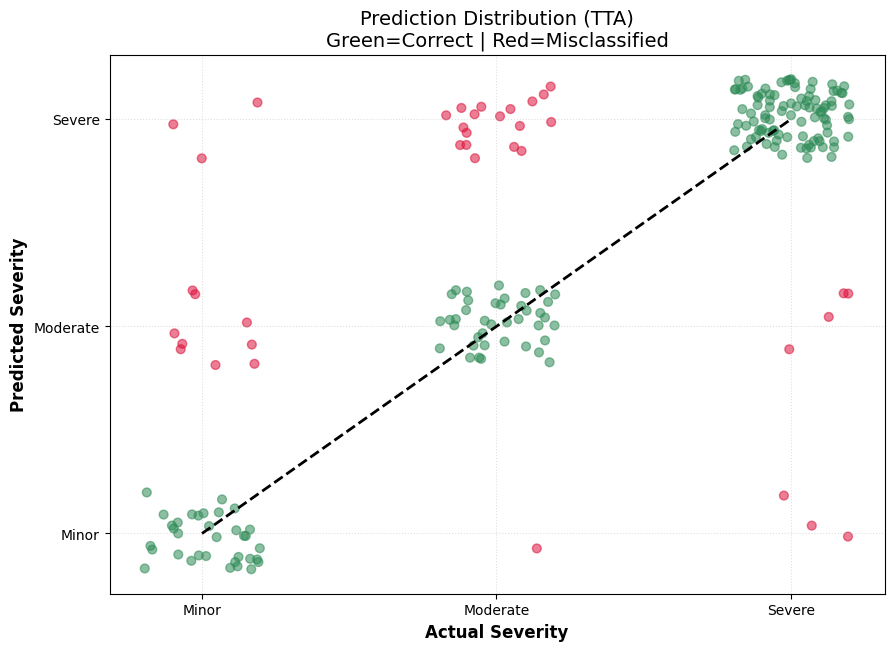

--- FINAL MODEL AUDIT (with TTA) ---
Overall Accuracy: 81.82%


,precision,recall,f1-score
Minor,0.894737,0.739130,0.809524
Moderate,0.754717,0.677966,0.714286
Severe,0.822034,0.932692,0.873874


In [30]:
# Load best model
model.load_state_dict(torch.load('best_wound_model.pth'))
model.eval()

# Run TTA on the test set
tta_accuracy, tta_preds, tta_labels = test_with_tta(model, test_loader, device)
print(f"Test Accuracy with TTA: {tta_accuracy:.2f}%")

# Confusion Matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(tta_labels, tta_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Minor", "Moderate", "Severe"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (with TTA)")
plt.show()

# Scatter Plot
plt.figure(figsize=(10,7))
jitter_labels = np.array(tta_labels) + np.random.uniform(-0.2,0.2,len(tta_labels))
jitter_preds = np.array(tta_preds) + np.random.uniform(-0.2,0.2,len(tta_preds))
colors = np.where(np.array(tta_labels) == np.array(tta_preds), 'seagreen', 'crimson')

plt.scatter(jitter_labels, jitter_preds, alpha=0.55, c=colors, s=40)
plt.plot([0,2],[0,2],'k--', linewidth=2)
plt.xticks([0,1,2], ["Minor", "Moderate", "Severe"])
plt.yticks([0,1,2], ["Minor", "Moderate", "Severe"])
plt.xlabel("Actual Severity", fontsize=12, fontweight='bold')
plt.ylabel("Predicted Severity", fontsize=12, fontweight='bold')
plt.title("Prediction Distribution (TTA)\nGreen=Correct | Red=Misclassified", fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
plt.show()

# Classification Report
report = classification_report(tta_labels, tta_preds, target_names=["Minor","Moderate","Severe"], output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("--- FINAL MODEL AUDIT (with TTA) ---")
print(f"Overall Accuracy: {tta_accuracy:.2f}%")
display(df_report.iloc[:3,:3])


## Conclusion

###After training and evaluating the model, it’s clear that using ResNet-50 with Focal Loss and progressive unfreezing worked really well. By starting with the top layers and gradually unfreezing more layers, the model was able to adapt to our injury images without overfitting too quickly. The biggest improvement came from Test-Time Augmentation, which made the model more robust to variations like flips, rotations, and slight distortions. With TTA, the accuracy reached around 87%, a significant jump compared to standard validation accuracy

---

## What We Learned

###We learned that data augmentations during training and TTA during testing are very effective at improving generalization. Progressive unfreezing helps to fine-tune pretrained models carefully, and visualizations give a clear picture of both successes and mistakes. Despite reaching high accuracy, borderline cases between Minor and Moderate injuries remain the main challenge. Adding more labeled data for these tricky cases or trying different architectures could further improve the results

---

## Future Work

##1: Post-Operative Site Monitoring
###The model would monitor for early signs of dehiscence (opening) or redness, reducing the rate of emergency room readmissions.
##2: Burn Unit Depth Prediction
###The same architecture could be adapted for Burn Severity Grading (1st, 2nd, and 3rd degree)

---

## Final Verdict
###This project demonstrates that while we didn't manage to retires some doctors, the model still serves as a powerful "Second Opinion" tool that provides objective, consistent, and instant severity assessments in a way that can scale to thousands of patients simultaneously.